# **Submission 1 - NLP with Tensorflow**

## **Muhammad Theda Amanda**

Dataset: https://www.kaggle.com/datasets/lokkagle/movie-genre-data

### **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### **Data Loading**

In [2]:
data = pd.read_csv('kaggle_movie_train.csv')
data.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


In [3]:
print('Data size:\n')
print(f'{data.shape[0]} rows')
print(f'{data.shape[1]} columns')

Data size:

22579 rows
3 columns


In [4]:
print("**"*20)
print(" "*10 + str('Dataset Information'))
print("**"*20)
data.info()

****************************************
          Dataset Information
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22579 entries, 0 to 22578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22579 non-null  int64 
 1   text    22579 non-null  object
 2   genre   22579 non-null  object
dtypes: int64(1), object(2)
memory usage: 529.3+ KB


### **Data Cleaning**

In [5]:
genre = pd.get_dummies(data.genre)
new_data = pd.concat([data, genre], axis=1)
new_data = new_data.sample(frac=1).reset_index()
new_data = new_data.drop(columns=['index', 'id'])
new_data.text = new_data.text.astype(str)
new_data

,text,genre,action,adventure,comedy,drama,horror,other,romance,sci-fi,thriller
0,s the music. PETER You busted me. FRIDA Are yo...,sci-fi,0,0,0,0,0,0,0,1,0
1,"r, and senses her aura of power. He drops his ...",action,1,0,0,0,0,0,0,0,0
2,"k, shakes a cigarette out of a pack, and taps ...",thriller,0,0,0,0,0,0,0,0,1
3,gth. Give us strength that surpasses all under...,drama,0,0,0,1,0,0,0,0,0
4,easing wail of ion engines. Suddenly four slee...,action,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
22574,"he bed of the pick up. Short leap, but harshly...",other,0,0,0,0,0,1,0,0,0
22575,s the window behind the shooter. Glass explode...,drama,0,0,0,1,0,0,0,0,0
22576,es its dirty work. Bruno rolls an empty barrel...,action,1,0,0,0,0,0,0,0,0
22577,n that chair for an hour. Smoking cigarettes a...,drama,0,0,0,1,0,0,0,0,0


### **Text Preprocessing**

In [6]:
# function to get all of strings from dataframe column, and used lower function here.
def get_all_str(df):
    sentence = ''
    for i in range(len(df)):
        sentence += df['text'][i]
    sentence = sentence.lower()
    return sentence

# function to get words from text(string). used RegexpTokenizer
def get_word(text):
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

# function to add stopwords to nltp stopword list.
def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

# function to remove stopwords from list.
def remove_stopword(stopwords, lst):
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist]
    return cleanwordlist

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
string = get_all_str(new_data)
words = get_word(string)
removed = remove_stopword('1',words)
print(removed[:10])

['music', 'peter', 'busted', 'frida', 'following', 'peter', 'embarrassing', 'returning', 'pillowcase', 'saw']


### **Tokenizing, Sequencing, dan Padding**

In [9]:
text = new_data['text'].values
label = new_data[['action', 'comedy',	'sci-fi', 'horror', 'drama', 'thriller', 'other', 'adventure', 'romance']].values

In [10]:
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2, random_state=42)
max_len = max([len(s.split()) for s in text_train])

In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token='<oov>', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(text_train)

sekuens_train = tokenizer.texts_to_sequences(text_train)
sekuens_test = tokenizer.texts_to_sequences(text_test)

padded_train = pad_sequences(sekuens_train, padding='post', maxlen=max_len, truncating='post')
padded_test = pad_sequences(sekuens_test, padding='post', maxlen=max_len, truncating='post')

### **Modeling**

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, None, 128)         98816     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0

### **Compile and Fit Model**

In [14]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [15]:
models_dir = 'save_models'
if not os.path.exists(models_dir):
  os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath=os.path.join(models_dir, 'model.hdf5'),
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")

stop_callback = myCallback()

callbacks = [stop_callback, checkpointer, reduce_learning_rate]

In [16]:
history = model.fit(padded_train, label_train, epochs=50, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.68844, saving model to save_models/model.hdf5
565/565 - 45s - loss: 1.0141 - accuracy: 0.6528 - val_loss: 0.8407 - val_accuracy: 0.6884 - lr: 0.0010 - 45s/epoch - 81ms/step
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.68844 to 0.85562, saving model to save_models/model.hdf5
565/565 - 16s - loss: 0.3581 - accuracy: 0.8857 - val_loss: 0.4522 - val_accuracy: 0.8556 - lr: 0.0010 - 16s/epoch - 27ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.85562 to 0.87002, saving model to save_models/model.hdf5
565/565 - 9s - loss: 0.2001 - accuracy: 0.9381 - val_loss: 0.4310 - val_accuracy: 0.8700 - lr: 0.0010 - 9s/epoch - 16ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.87002
565/565 - 10s - loss: 0.1327 - accuracy: 0.9585 - val_loss: 0.4924 - val_accuracy: 0.8525 - lr: 0.0010 - 10s/epoch - 18ms/step
Epoch 5/50

The accuracy of the training set and the validation set has reached > 90%!

Epoch 5: val_accuracy improved from 0.87002 to 0.90080, saving model to save_models/model.hdf5
565/565 - 12s - loss: 0.0784 - accuracy: 0.9747 - val_loss: 0.3775 - val_accuracy: 0.9008 - lr: 2.0000e-04 - 12s/epoch - 21ms/step


### **Evaluate Model**

In [17]:
model.evaluate(padded_test, label_test)

142/142 [==============================] - 1s 7ms/step - loss: 0.3775 - accuracy: 0.9008


[0.3774590790271759, 0.9007971882820129]

### **Plot Accuracy & Loss**

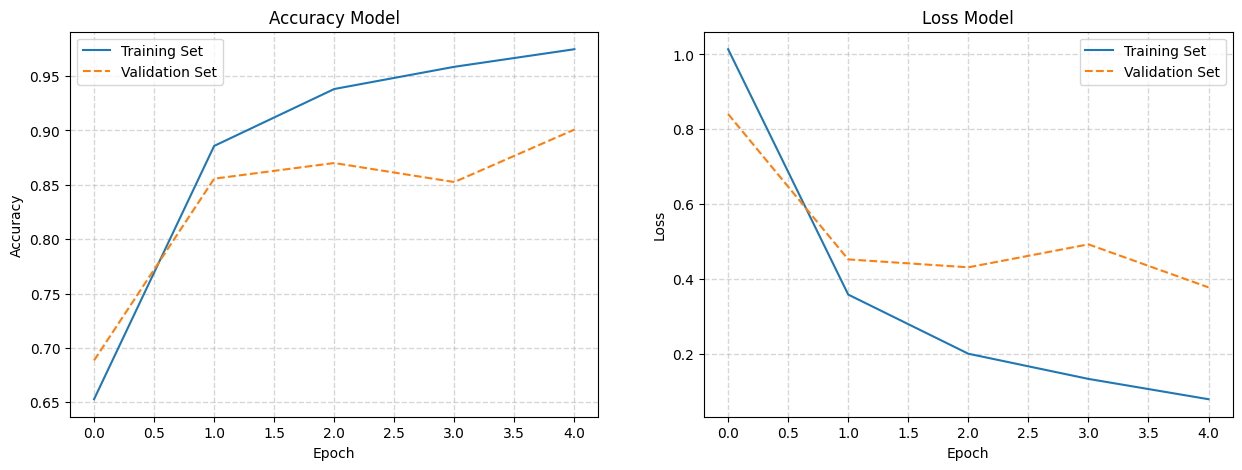

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], linestyle='--')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'])
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle='--')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'])
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()